# Radiocarbon

In this tutorial, we will simulate the radiocarbon age using the AIBECS by
1. defining the transport `T(p)` and the sources and sinks `G(x,p)`,
1. defining the parameters `p`,
1. generating the state function `F(x,p)` and solving the associated steady-state problem,
1. and finally making a plot of our simulated radiocarbon age.

> *Note*
> Although this tutorial is self-contained, it involves non-linearitiess and is slightly more complicated than the first tutorial for simulating the ideal age.
> (So do not hesitate to start with the ideal-age tutorial if you wish.)

The tracer equation for radiocarbon is

$$\big(\partial_t + \mathbf{T} \big) \boldsymbol{R} = \frac{\lambda}{h} (\overline{\boldsymbol{R}}_\mathsf{atm} - \boldsymbol{R}) (\boldsymbol{z} ≤ h) - \boldsymbol{R} / \tau.$$

where the first term on the right of the equal sign represents the air–sea gas exchange with a piston velocity $λ$ over a depth $h$ and the second term represents the radioactive decay of radiocarbon with timescale $\tau$.

> Note:
> We need not specify the value of the atmospheric radiocarbon concentration because it is not important for determining the age of a water parcel — only the relative concentration $\boldsymbol{R}/\overline{\boldsymbol{R}}_\mathsf{atm}$ matters.

We start by selecting the circulation for Radiocarbon

In [1]:
using AIBECS
grd, T_OCIM1 = OCIM1.load()
T(p) = T_OCIM1

Loading OCIM1┌ Warning: Over-writing registration of the datadep
│   name = AIBECS_OCIM1
└ @ DataDeps /home/travis/.julia/packages/DataDeps/ai3FE/src/registration.jl:8
 ✔
┌ Info: You are about to use OCIM1 model.
│ If you use it for research, please cite:
│ 
│ - DeVries, T., 2014: The oceanic anthropogenic CO2 sink: Storage, air‐sea fluxes, and transports over the industrial era, Global Biogeochem. Cycles, 28, 631–647, doi:10.1002/2013GB004739.
│ - DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, doi:10.1175/JPO-D-10-05011.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Primeau_2011" and "DeVries_2014" keys.)
└ @ AIBECS.OCIM1 /home/travis/build/briochemc/AIBECS.jl/src/OCIM1.jl:54


T (generic function with 1 method)

The local sources and sinks are simply given by

In [2]:
function G(R,p)
    @unpack λ, h, R̅atm, τ = p
    return @. λ / h * (R̅atm - R) * (z ≤ h) - R / τ
end

G (generic function with 1 method)

We can define `z` via

In [3]:
z = depthvec(grd)

200160-element Array{Float64,1}:
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
    ⋮              
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175

In this tutorial we will specify some units for the parameters.
Such features **must** be imported to be used

In [4]:
import AIBECS: @units, units

We define the parameters using the dedicated API from the AIBECS, including keyword arguments and units this time

In [5]:
@units struct RadiocarbonParameters{U} <: AbstractParameters{U}
    λ::U    | u"m/yr"
    h::U    | u"m"
    τ::U    | u"yr"
    R̅atm::U | u"M"
end

units (generic function with 20 methods)

For the air–sea gas exchange, we use a constant piston velocity $\lambda$ of 50m / 10years.
And for the radioactive decay we use a timescale $\tau$ of 5730/log(2) years.

In [6]:
p = RadiocarbonParameters(λ = 50u"m"/10u"yr",
                          h = grd.δdepth[1],
                          τ = 5730u"yr"/log(2),
                          R̅atm = 42.0u"nM")


│ Row │ Symbol │ Value   │ Unit     │
│     │ Symbol │ Float64 │ Unitful… │
├─────┼────────┼─────────┼──────────┤
│ 1   │ λ      │ 5.0     │ m yr^-1  │
│ 2   │ h      │ 36.1351 │ m        │
│ 3   │ τ      │ 8266.64 │ yr       │
│ 4   │ R̅atm   │ 4.2e-8  │ M        │

> *Note*
> The parameters are converted to SI units when unpacked.
>  When you specify units for your parameters, you must supply their values in that unit.

We generate the state function and its Jacobian, generate the corresponding steady-state problem, and solve it, via

In [7]:
F, ∇ₓF = state_function_and_Jacobian(T, G)
x = zeros(length(z)) # an initial guess
prob = SteadyStateProblem(F, ∇ₓF, x, p)
R = solve(prob, CTKAlg()).u

200160-element Array{Float64,1}:
 3.5608397404900134e-5
 3.5556059176127604e-5
 3.5474448117218726e-5
 3.55295822211992e-5  
 3.588434898329019e-5 
 3.598710525374608e-5 
 3.5869469058303054e-5
 3.59399120359603e-5  
 3.611772018562453e-5 
 3.6368553035307756e-5
 ⋮                    
 3.670248839914152e-5 
 3.673344563611749e-5 
 3.666322161420394e-5 
 3.6682122167721095e-5
 3.671434261992305e-5 
 3.67781279552919e-5  
 3.668657506711626e-5 
 3.6704426439685504e-5
 3.672669545818869e-5 

This should take a few seconds on a laptop.
Once the radiocarbon concentration is computed, we can convert it into the corresponding age in years, via

In [8]:
@unpack τ, R̅atm = p
C14age = @. log(R̅atm / R) * τ * u"s" |> u"yr"

200160-element Array{Quantity{Float64,𝐓,Unitful.FreeUnits{(yr,),𝐓,nothing}},1}:
 1364.7245332231976 yr
 1376.8840164695225 yr
 1395.8800726009727 yr
  1383.042096468035 yr
 1300.9081458766334 yr
 1277.2701118626908 yr
 1304.3367306312928 yr
   1288.11803895663 yr
  1247.320711598418 yr
 1190.1083953568188 yr
                     ⋮
  1114.550596728037 yr
 1107.5809181367922 yr
 1123.3995401227025 yr
 1119.1390345207467 yr
 1111.8810560843567 yr
 1097.5315397900845 yr
 1118.1355949287629 yr
 1114.1140959288994 yr
 1109.1001449622108 yr

and plot it at 700 m using the `horizontalslice` Plots recipe

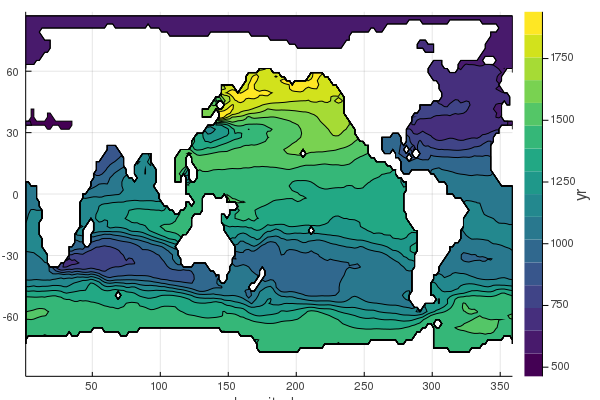

In [9]:
using Plots
horizontalslice(C14age, grd, 700; color=:viridis)

look at a zonal average using the `zonalaverage` plot recipe

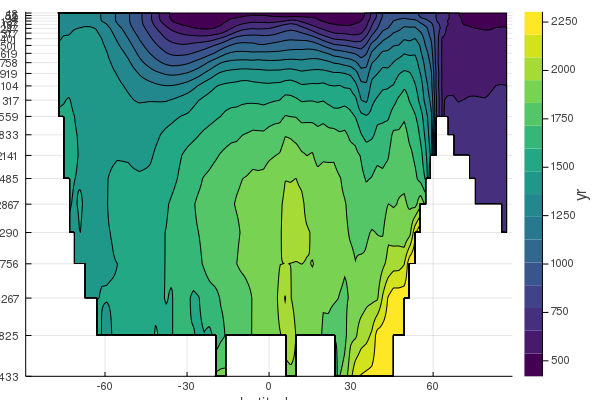

In [10]:
zonalaverage(C14age, grd; color=:viridis)

or look at a zonal slice through the Atlantic at 30°W using the `zonalslice` plot recipe

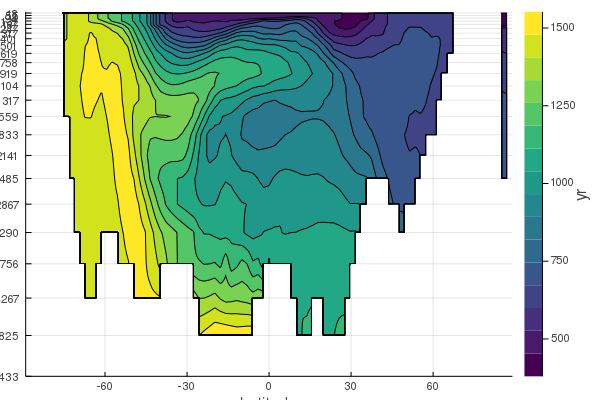

In [11]:
zonalslice(C14age, grd, -30; color=:viridis)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*